# Evaluating speech polarization over time

#### Setup path and key variables
Append the path to the project module and set up date range, path to data, etc.

In [4]:
import os
import sys
PATH = "."
PATH_DATA = os.path.join(PATH, "data/clean")
START = '2020_02_23'
END = '2020_07_15'
NUM_WORKERS = 3
sys.path.append(os.path.join('.', 'src'))
topic_subset = ['2', '4', '7', '8', '10', '11', '12', '13', '14', '17', '22', '24', '25', '27', '28']

#### Load libraries

In [5]:
# data manipulation and linear algerba:
import numpy as np
import pandas as pd
import pandarallel
pandarallel.pandarallel.initialize(nb_workers = NUM_WORKERS)

# visualization set up:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
})

# utilities
import gc
import json
import pickle
import random
from tqdm.notebook import tqdm, trange
from functools import partial
import ast
import nltk

# models and own utility functions:
from twitter_models.polarization import ModelPolarization
from twitter_tools.utils import read_files, read_window, translate
from twitter_tools.evaluation import polarization as evaluation

# statistics stuff:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

# ipython API:
import ipywidgets as widgets
from ipywidgets import interact

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


#### Load utility files
This includes stopwords, list of redundant user and tweet IDs and topic assignment dictionaries obtained in previous notebooks.

In [6]:
# stopwords:
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        word = line.strip('\n')
        if word != 'nie':
            stopwords.append(word)
stopwords.append('mieć')
dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
topic_dict = json.load(open(PATH_DICT, 'r'))
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
PATH_TOKENS = os.path.join(PATH, 'results/topics/mallet/topic_tokens.json')
topic_tokens = json.load(open(PATH_TOKENS, 'r'))


# Get random assignment
gov = pickle.load(open(os.path.join(PATH, 'data/sample/gov_sample.p'),"rb"))
opp = pickle.load(open(os.path.join(PATH, 'data/sample/opp_sample.p'),"rb"))
parties = {k: "gov" for k in gov}
parties.update({k: "opp" for k in opp})
random.seed(1234)
random_keys = list(parties.keys()); random.shuffle(random_keys) #randomize keys
random_values = list(parties.values()); random.shuffle(random_values) #randomize values
randomized = dict(zip(random_keys, random_values)) #zip into dict


# read IDs to be removed
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))

#### Define utility functions:

In [41]:
# filter function:
def filter_fun(df:pd.DataFrame, drop_users:list, 
               drop_tweets:list, drop_duplicates:bool = True, 
               keep_cols:list = None, **kwargs):
    """
    Function to filter the read data frame.
    df - pd.DataFrame 
    drop_users:list - IDs of users to drop
    drop_tweets: list - IDs of tweets to drop
    drop_duplicates: bool, whether to drop duplicates
    keep_cols: columns to keep. If None, keeps all
    **kwargs - provided to the pd.DataFrame.drop_duplicates method
    
    """
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True, **kwargs)
    if keep_cols is not None:
        df = df[keep_cols]
    return df

# partial filter function, with preset filters
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, 
             subset = ['lemmatized'], keep_cols = ['full_text', 'day','lemmatized','id_str','user-id_str', 'source', 'lemmas'])

def weighted_average(group:pd.DataFrame, value_name:str = 'score', weight_name:str = 'n'):
    """
    function to compute weighted average in pd.DataFrame.groupby
    group.
    group - dataframe roup groupped dataframe
    value_name: str, name of the value variable
    weight_name: str, name of the weight variable
    """
    weights = group[weight_name]
    score = group[value_name]   
    return np.average(score, weights=weights)

def ols_fit(X, Y):
    """
    function to fit ols describing the time trend
    X: NxM, array-like
    Y: Nx1 array-like
    """
    X = sm.add_constant(X)
    Y = Y
    model = sm.OLS(Y, X)
    fit = model.fit()
    res = fit.conf_int()
    res.columns = ['lower','upper']
    res['point'] = fit.params
    res['pvalues'] = fit.pvalues
    return res

*The leave-out estimator of partisanship is obtained using the following process. Each user's speech-generating process is assumed to follow a multinomial distribution over the possible phrase set, where each phrase is picked with a certain choice probability. The*


\begin{equation}
\hat{\pi}_{t}^{LO} = \frac{1}{2} \frac{1}{|R_{t}|} \sum_{i \in R_{t}} \hat{q}_{i,t}  \cdot \hat{p}_{-i,t} +  \frac{1}{2} \frac{1}{|D_{t}|} \sum_{i \in D_{t}} \hat{q}_{i,t}  \cdot (1 - \hat{p}_{-i,t})\\
\end{equation}


$\hat{p}_{-i,t} = \hat{q}_{-i,t}^{R} / (\hat{q}_{-i,t}^{R} + \hat{q}_{-,it}^{D})$ is the probability of an observer with a neutral prior assigning a speaker to government based only on a given phrase



$\hat{q}_{i,t} = c_{i,t} / m_{i,t}$ are the phrase frequencies for speaker $i$ at time $t$ 




# 1. Partisanship over time - day level

### 1.1 Overall partisanship
- using all data
- excluding duplicated Tweets

#### Day-level estimates: 

In [62]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col=0)
else:
    results = dict() #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = data['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit=40, ngram_range=(1,2))
        results[(day, 'true')] = model.estimate(parties, users, tweets, level="aggregate", conf_int=100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit=40, ngram_range=(1,2))
        results[(day, 'random')] = model.estimate(random_parties, users, tweets, level="aggregate", conf_int=100)
    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.to_csv(PATH_RESULTS)

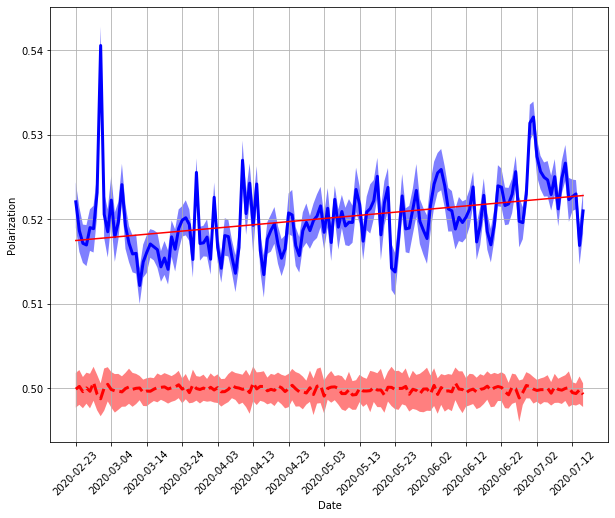

In [60]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop=True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop=True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop=True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, 
                           trend_line=True, tick_freq=10, ax=ax)
plt.show()

In [64]:
fits = ols_fit(np.arange(0, results['date'].shape[0]), results['estimate'])
fits = fits.rename(columns={'point':'estimate','pvalues':'p-value'})
fits = fits[['estimate','p-value']].T.rename(columns={'x1':'trend'})
print(fits)
fits.to_latex(os.path.join(PATH, 'final/tables/polarization_overall_ols.tex'), header = ['constant', 'trend'], )

             const     trend
estimate  0.508833  0.000008
p-value   0.000000  0.268171


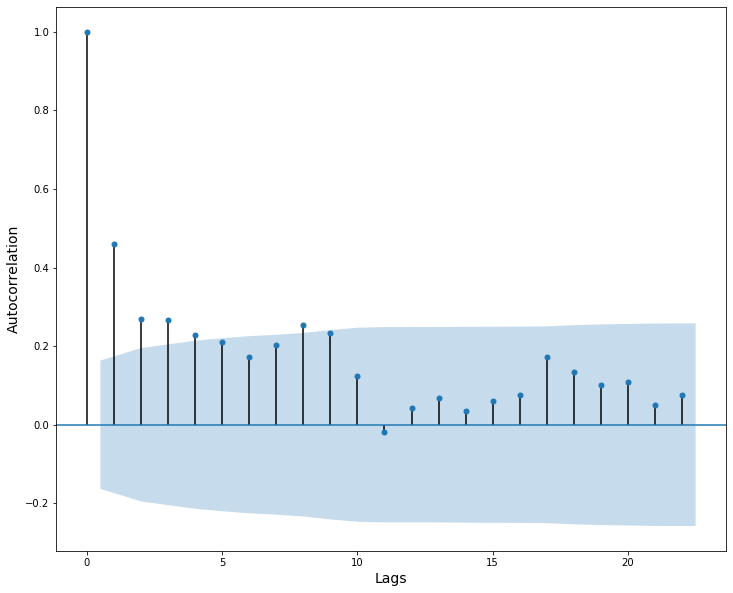

In [27]:
results.reset_index(inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_acf(results[results.type == 'true'].estimate, ax=ax, title=None)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14)
plt.savefig(os.path.join(PATH, 'final/figures/autocorrelation_overall.png'))
plt.show()

#### Day-level smoothed estimates
To obtained "smoother" version of the daily the estimates, I use rolling-window of 7 days to compute the vocabulary on which the estimates are based. For example, the "smoothed" estimate for 5th of March uses the vocabulary between the 2th and 8th of March to fit the ngram tokenizer, and then only phrases used on the 5th to compute the polarization on that particular day.

In [38]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_window.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col=0)
else:
    results = dict()
    for df in tqdm(read_window(PATH_DATA, n=7, batch_size=1,
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        # fit vectorizer on all vocabulary:
        model = ModelPolarization(parties=["gov", "opp"], limit=40, ngram_range=(1, 2),
                                  log=20, n_jobs=4, stop_words=stopwords)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        results[(mid_date, 'true')] = model.estimate(df['source'],
                                                     df['user-id_str'],
                                                     df['lemmatized'],
                                                     level='aggregate',
                                                     conf_int=100,
                                                     leave_out=True)
        random_parties = df["user-id_str"].astype(str).apply(lambda x: randomized.get(x))
        results[(mid_date, 'random')] = model.estimate(random_parties,
                                                       df['user-id_str'],
                                                       df['lemmatized'],
                                                       level='aggregate',
                                                       conf_int=100,
                                                       leave_out=True)

    results = pd.DataFrame.from_dict(results, orient='index')
    results.index.names = ['date', 'type']
    results.to_csv(PATH_RESULTS)
results.reset_index(inplace=True)

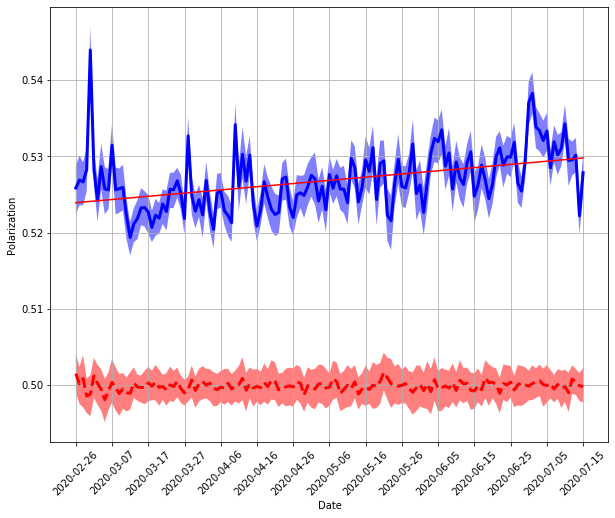

In [39]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, 
                           trend_line=True, tick_freq=10, ax=ax)
plt.savefig(os.path.join(PATH, 'final/figures/polarization_moving_window.png'))
plt.show()

#### Robustness to Tweet length:
Re-run the estimation for long tweets only to see whether that affect the patrtisanship estimates.

In [16]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_window_test.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col=0)
else:
    results = dict()
    for df in tqdm(read_window(PATH_DATA, n=7, batch_size=1,
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        df['ntokens'] = df['lemmas'].apply(lambda x: len(ast.literal_eval(x)))
        df = df.loc[df['ntokens'] >= df['ntokens'].median(), :]
        # fit vectorizer on all vocabulary:
        model = ModelPolarization(parties=["gov", "opp"], limit=40, ngram_range=(1, 2),
                                  log=20, n_jobs=4, stop_words=stopwords)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        results[(mid_date, 'true')] = model.estimate(df['source'],
                                                     df['user-id_str'],
                                                     df['lemmatized'],
                                                     level='aggregate',
                                                     conf_int=100,
                                                     leave_out=True)
        random_parties = df["user-id_str"].astype(str).apply(lambda x: randomized.get(x))
        results[(mid_date, 'random')] = model.estimate(random_parties,
                                                       df['user-id_str'],
                                                       df['lemmatized'],
                                                       level='aggregate',
                                                       conf_int=100,
                                                       leave_out=True)

    results = pd.DataFrame.from_dict(results, orient='index')
    results.index.names = ['date', 'type']
    results.to_csv(PATH_RESULTS)

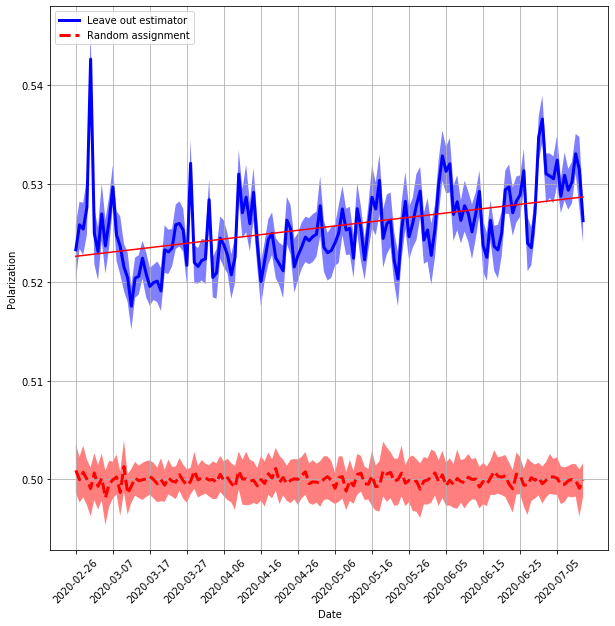

In [9]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop=True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line=True, tick_freq=10)
plt.show()

**Linear fit coefficients**:

#### Robustness to vocabulary window size
Compute the partisanship estimates on weely level, to see whether that affects the resulting trend.

In [79]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly.csv")
if os.path.isfile(PATH_RESULTS):
    results = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    results = dict() #store for each day
    for data in tqdm(read_files(PATH_DATA, day_from=START, day_to=END, dtype=dtypes, filter_fun=ff, batch_size=7)):
        parties = data["source"] #get parties 
        users = data["user-id_str"] #get users 
        tweets = data["lemmatized"].astype(str) #get tweets
        day = sorted(pd.to_datetime(data['day'].unique()))[3]
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[(day, 'true')] = model.estimate(parties, users, tweets, 
                                                               level = "aggregate", conf_int=100)

        #randomization
        random_parties = data["user-id_str"].astype(str).map(randomized)
        model = ModelPolarization(parties = ["gov", "opp"], limit = 40, ngram_range = (1,2))
        results[(day, 'random')] = model.estimate(random_parties, users, tweets, 
                                                               level = "aggregate", conf_int=100)
    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.to_csv(PATH_RESULTS)

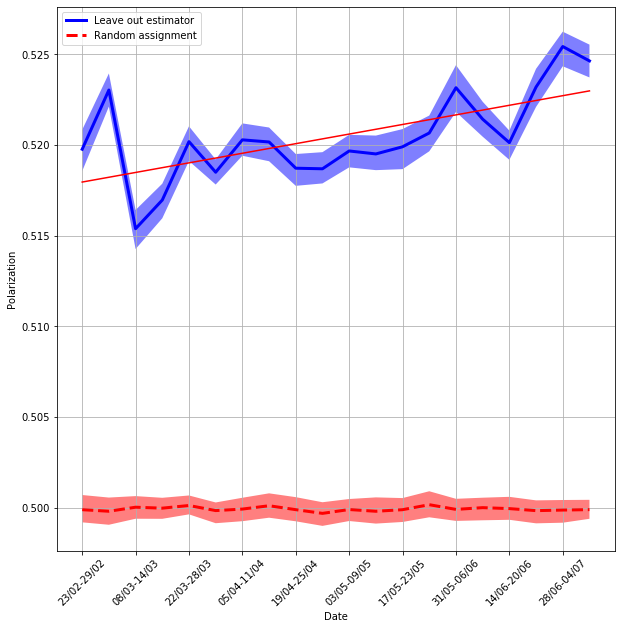

In [80]:
results.set_index(['date','type'], inplace = True)
date = results.reset_index().date.unique()
true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop = True)
true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop = True)
random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop = True)
evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, trend_line = True, tick_freq = 2)
plt.show()

**Linear trend coefficients**

In [83]:
results.reset_index(inplace=True)
fits = results.groupby('type').apply(lambda x: ols_fit_time(x['date'], x['estimate']))
fits['pvalues'] = fits.pvalues.round(4)
fits

lower     upper     point  pvalues
type                                               
random const  0.499834  0.500051  0.499943   0.0000
       x1    -0.000011  0.000008 -0.000002   0.7315
true   const  0.516197  0.519732  0.517964   0.0000
       x1     0.000106  0.000424  0.000265   0.0026

#### Both plots in one figures for the paper

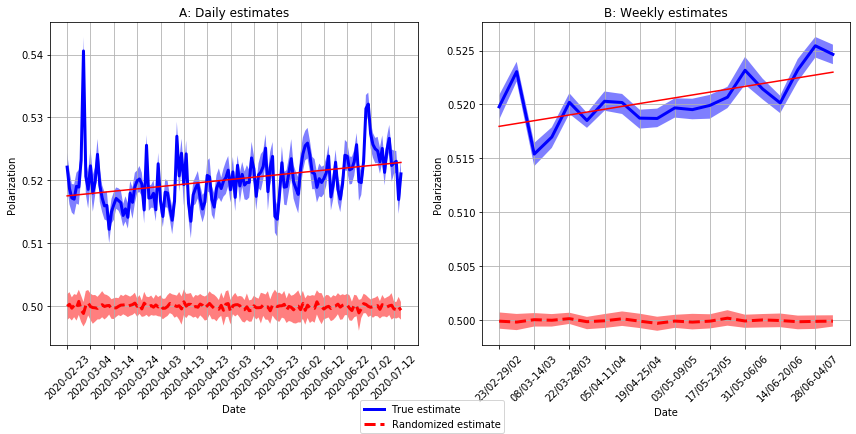

In [16]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.ravel()
freqs = [10, 2]
titles = ['A: Daily estimates', 'B: Weekly estimates']
for i, file in enumerate(['polarization_daily.csv', 'polarization_weekly.csv']):
    
    PATH_RESULTS = os.path.join(PATH, "results/polarization", file)
    results = pd.read_csv(PATH_RESULTS, index_col=0)
    results.set_index(['date','type'], inplace=True)
    date = results.reset_index().date.unique()
    true_estimate = results.loc[pd.IndexSlice[:, 'true'], 'estimate'].reset_index(drop=True)
    true_ci = results.loc[pd.IndexSlice[:, 'true'], ('lower_ci', 'upper_ci')].reset_index(drop=True)
    random_estimate = results.loc[pd.IndexSlice[:, 'random'], 'estimate'].reset_index(drop=True)
    random_ci = results.loc[pd.IndexSlice[:, 'random'], ('lower_ci', 'upper_ci')].reset_index(drop=True)
    evaluation.plot_aggregated(date, true_estimate, random_estimate, true_ci, random_ci, 
                               trend_line=True, tick_freq=freqs[i], ax=ax[i], legend=False)
    ax[i].set_title(titles[i])
plt.tight_layout()
plt.figlegend(['True estimate', 'Randomized estimate'], bbox_to_anchor=(0.5, -0.01), loc='lower center')
plt.savefig(os.path.join(PATH, 'final/figures/polarization_overall.png'))
plt.show()

### 1.2 Within-topics partisanship, based on the LDA-Mallet topic model

#### Day-level estimates of topic partisanship

In [203]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_topics.csv")
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
if os.path.isfile(PATH_RESULTS):
    part_within = pd.read_csv(PATH_RESULTS, index_col=0)
else:
    part_within = dict() #store estimates
    for df in tqdm(read_window(PATH_DATA, n=7,  batch_size=1, day_from=START, day_to=END, 
                               dtype=dtypes, filter_fun=ff)):
        
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit=40, ngram_range=(1,2), log=20)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        df['topic'] = df['id_str'].apply(lambda x: topic_map.get(x))
        #get estimates by topic:
        part_within_t = data.groupby('topic').parallel_apply(lambda gr: model.estimate(gr['source'], 
                                                                                       gr['user-id_str'], 
                                                                                       gr['lemmatized'], 
                                                                                       level = 'aggregate',
                                                                                       conf_int = None))
        part_within_t = part_within_t.to_dict() #convert to dict
        part_within_t = {(k, mid_date):v for k, v in part_within.items()}
        part_within.update(part_within_t) #update all
    part_within = pd.DataFrame.from_dict(part_within, orient = 'index')

    part_within.index.names = ['topic','date']
    part_within.reset_index(inplace = True)
    part_within[['gov','opp']] = pd.json_normalize(part_within['n'])
    del part_within['n']
    part_within.set_index(['topic','date'], inplace = True)
    part_within['n'] = part_within['gov'] + part_within['opp']
    part_within.to_csv(PATH_RESULTS)
part_within = part_within.reset_index()
part_within = part_within[part_within['topic'] > 0] # filter out "difficult to identify"
# add topic labels
part_within['topic_label'] = part_within['topic'].astype(str) + ' ' + part_within['topic'].astype(str).map(topic_dict)

#### All:

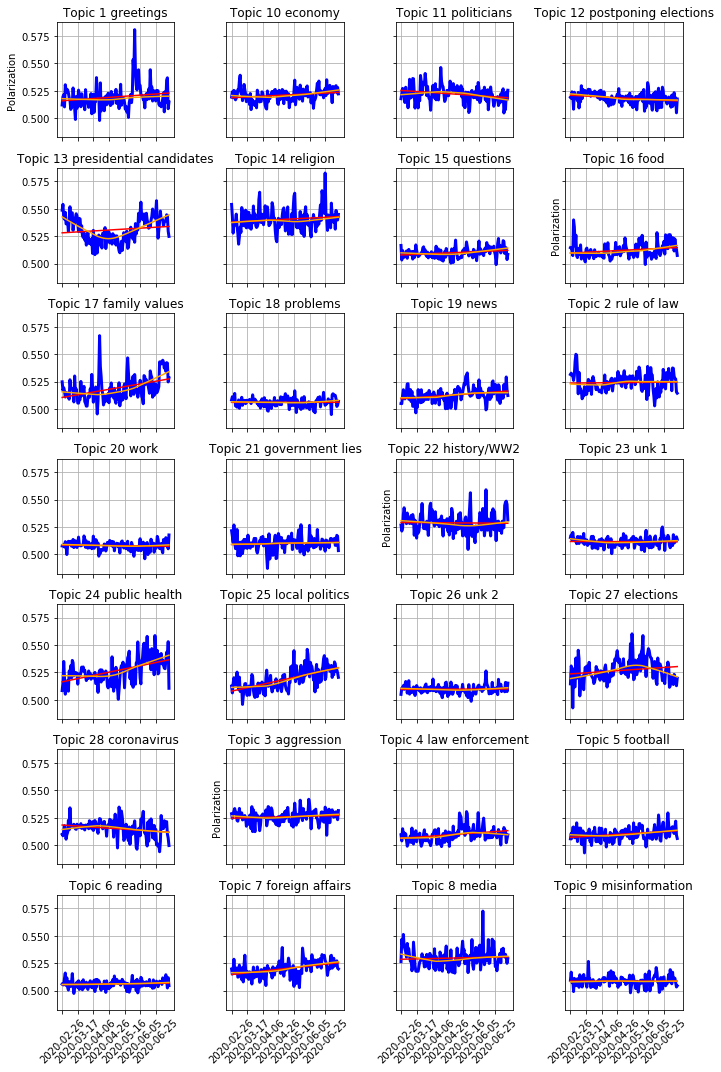

In [204]:
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
topic_dict = json.load(open(PATH_DICT, 'r'))
evaluation.plot_aggregated_bytopic(part_within.date, part_within.point, 
                                   part_within.topic_label, figsize=(10, 15), 
                                   trend_line=True, lowess=True, dims=(7, 4))
plt.savefig(os.path.join(PATH, 'final/figures/polarization_topics_all.png'), bbox_inches='tight', pad_inches=0.2)
plt.tight_layout()
plt.show()

#### Selected topics:

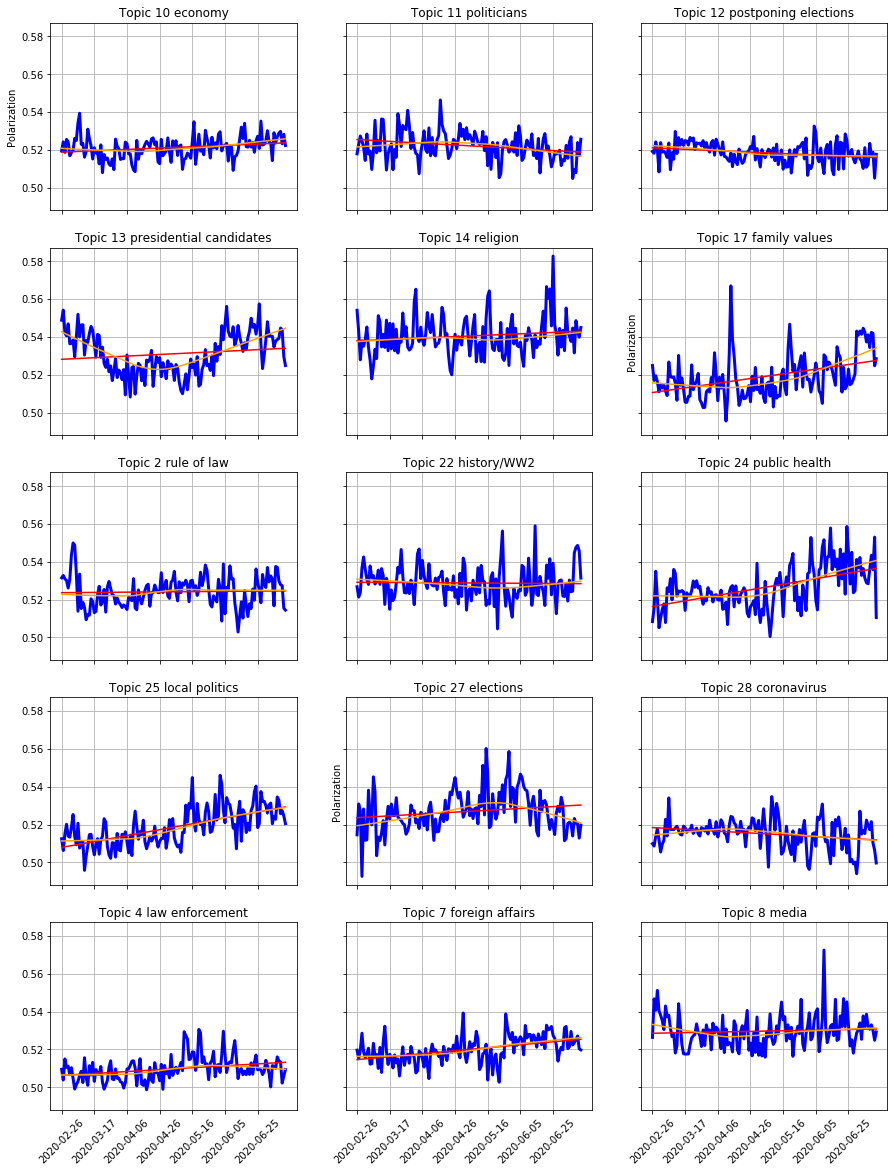

In [205]:
part_within_plt = part_within[part_within.topic.astype(str).isin(topic_subset)]
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
topic_dict = json.load(open(PATH_DICT, 'r'))
evaluation.plot_aggregated_bytopic(part_within_plt.date, part_within_plt.point, 
                                   part_within_plt.topic_label, figsize=(15, 20), 
                                   trend_line=True, lowess=True, dims=(5, 3))
plt.savefig(os.path.join(PATH, 'final/figures/polarization_topics.png'))
plt.show()

#### Polarization autocorrelation within each topic:
To examine the presence of the trend, I have also plotted the autocorrelation of each topic-polarization time series for 20 lags.

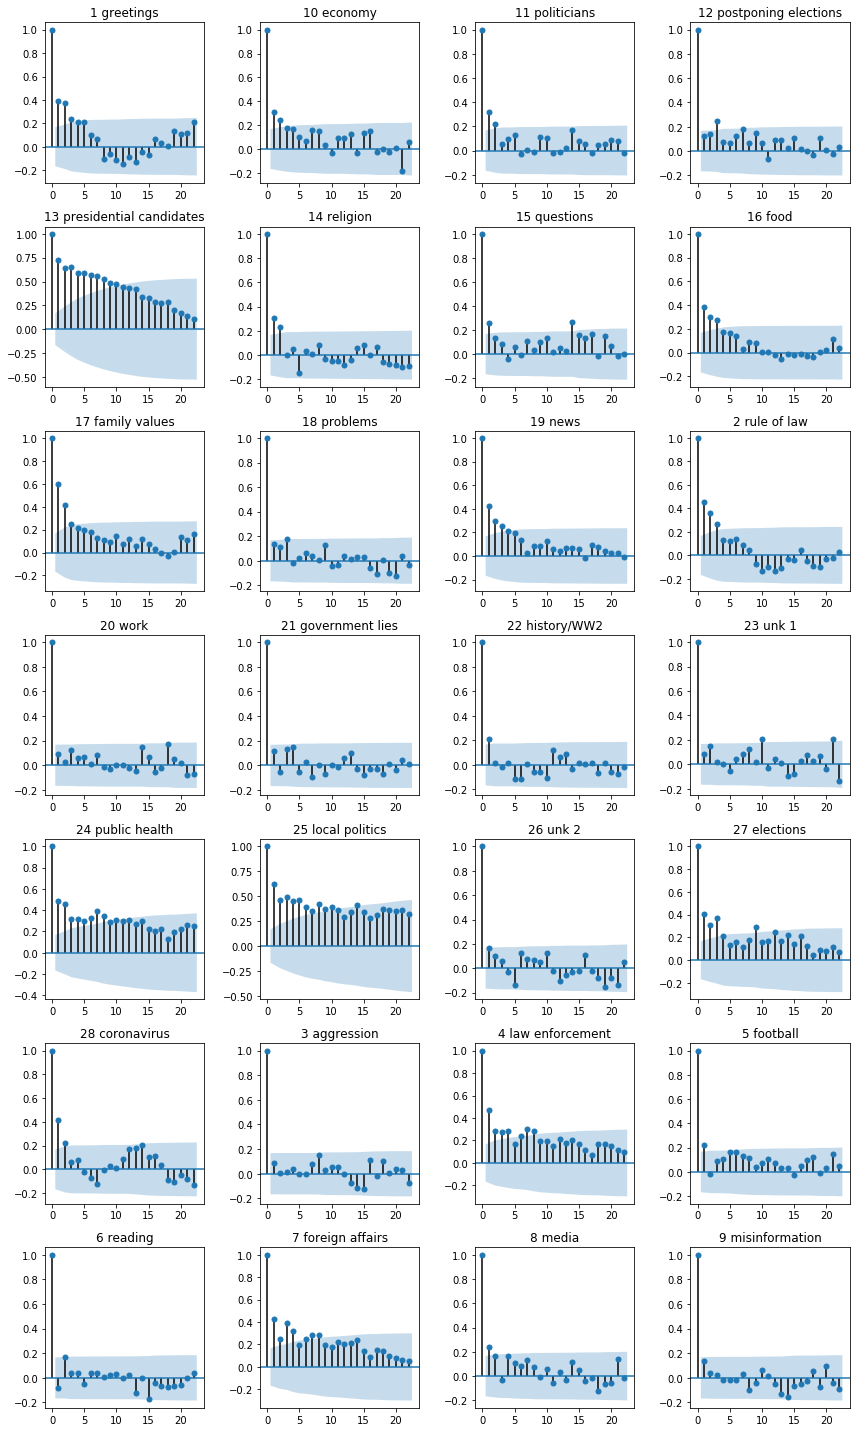

In [206]:
fig, ax = plt.subplots(7, 4, figsize=(12, 20))
ax = ax.ravel()
for i, (topic, df) in enumerate(part_within.groupby('topic_label')):
    plot_acf(df['point'], ax=ax[i])
    ax[i].set_title(f'{topic}')
plt.tight_layout()
    plt.savefig(os.path.join(PATH, 'final/figures/topics_autocorrelation.png'), bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Linear fits:
To further investigates trends within each of the topics, I fitted an OLS regression for each of them, and examined the slope and the intercept.

In [207]:
date_num = np.arange(0, len(part_within['date'].unique()))
fits = part_within.groupby(['topic', 'topic_label']).apply(lambda gr: ols_fit(date_num, gr['point']))
fits['err'] = fits['upper'] - fits['point']
fits = fits.reset_index().rename(columns={'level_2':'coef'})

#### Regression table:

In [208]:
fits_tbl = fits[['topic_label', 'coef', 'point', 'pvalues']]
fits_tbl.loc[:,'coef'] = fits_tbl['coef'].map({'const':'constant', 'x1':'slope'})
fits_tbl.loc[:,'pvalues'] = fits_tbl['pvalues'].round(5)
fits_tbl = fits_tbl.rename(columns = {'pvalues':'p-value', 'topic_label':'topic'})
fits_tbl = fits_tbl.pivot(index=['topic'], columns=['coef']).reorder_levels(['coef',None], axis=1)
fits_tbl = fits_tbl[[('constant','point'), ('constant','p-value'), 
                    ('slope', 'point'), ('slope','p-value')]]
print(fits_tbl)
fits_tbl.to_latex(os.path.join(PATH, 'final/tables/polarization_topics_ols.tex'))

coef                        constant                 slope         
                               point p-value         point  p-value
topic                                                              
1 greetings                 0.515911     0.0  5.175950e-05  0.02039
10 economy                  0.518711     0.0  3.582105e-05  0.00377
11 politicians              0.525369     0.0 -4.825511e-05  0.00197
12 postponing elections     0.520982     0.0 -3.747630e-05  0.00124
13 presidential candidates  0.528101     0.0  4.248237e-05  0.07109
14 religion                 0.537868     0.0  3.685980e-05  0.08384
15 questions                0.507954     0.0  3.061105e-05  0.00113
16 food                     0.509692     0.0  3.685185e-05  0.00915
17 family values            0.510574     0.0  1.232232e-04  0.00000
18 problems                 0.506099     0.0  9.125505e-07  0.91459
19 news                     0.509364     0.0  5.157463e-05  0.00023
2 rule of law               0.523653     0.0  6.

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Plot: 

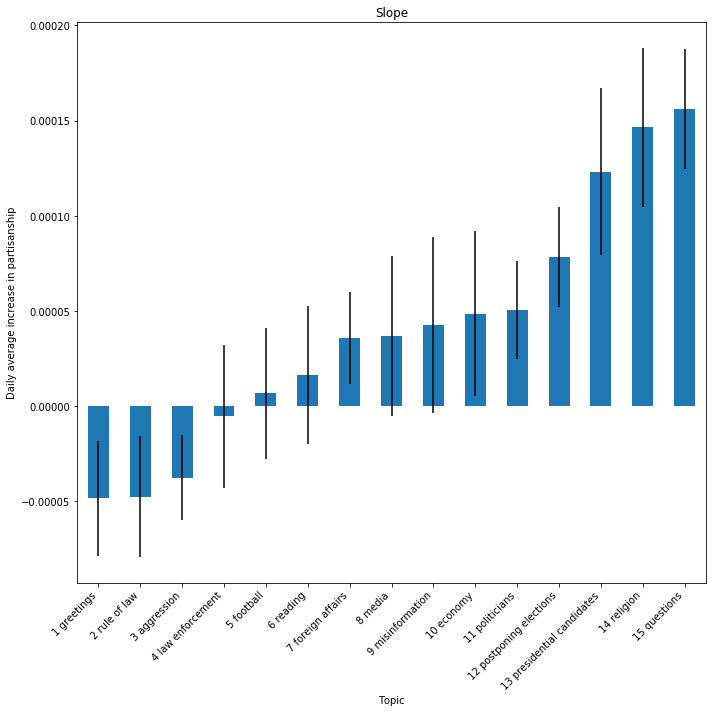

In [209]:
fits_plt = fits[fits['topic'].isin(topic_subset)]
fits_plt = fits_plt[fits_plt['coef'] != 'const'].sort_values('point')
ax = fits_plt.plot.bar('topic_label','point',figsize=(10, 10), yerr='err')
ax.get_legend().remove()
ax.set_xticklabels(fits['topic_label'].unique(), rotation=45, ha='right')
ax.set_ylabel('Daily average increase in partisanship')
ax.set_xlabel('Topic')
ax.set_title('Slope')
plt.tight_layout()
plt.savefig(os.path.join(PATH, 'final/figures/partisanship_topics_coef.png'), bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Quadratic fits:

In [210]:
date_num = np.arange(0, len(part_within['date'].unique()))
fits = part_within.groupby(['topic','topic_label']).apply(lambda gr: ols_fit(np.c_[date_num, date_num**2], gr['point']))
fits['err'] = fits['upper'] - fits['point']
fits = fits.reset_index().rename(columns={'level_2':'coef'})

#### Regression table:

In [211]:
fits_tbl = fits[['topic_label', 'coef', 'point', 'pvalues']]
fits_tbl['coef'] = fits_tbl['coef'].map({'const':'constant', 'x1':'linear slope', 'x2':'quadratic slope'})
fits_tbl['pvalues'] = fits_tbl['pvalues'].round(5)
fits_tbl = fits_tbl.rename(columns = {'pvalues':'p-value', 'topic_label':'topic'})
fits_tbl = fits_tbl.pivot(index=['topic'], columns=['coef']).reorder_levels(['coef',None], axis=1)
fits_tbl = fits_tbl[[('constant','point'), ('constant','p-value'), 
                    ('linear slope', 'point'), ('linear slope','p-value'), 
                    ('quadratic slope','point'), ('quadratic slope','p-value')]]
print(fits_tbl)
fits_tbl.to_latex(os.path.join(PATH, 'final/tables/polarization_topics_ols_quadratic.tex'))

coef                        constant         linear slope           \
                               point p-value        point  p-value   
topic                                                                
1 greetings                 0.515493     0.0     0.000070  0.42600   
10 economy                  0.522183     0.0    -0.000117  0.01281   
11 politicians              0.521849     0.0     0.000107  0.07383   
12 postponing elections     0.521489     0.0    -0.000060  0.18810   
13 presidential candidates  0.543643     0.0    -0.000643  0.00000   
14 religion                 0.538832     0.0    -0.000006  0.94630   
15 questions                0.510006     0.0    -0.000060  0.09659   
16 food                     0.513999     0.0    -0.000153  0.00446   
17 family values            0.517798     0.0    -0.000195  0.02048   
18 problems                 0.507390     0.0    -0.000056  0.09640   
19 news                     0.509431     0.0     0.000049  0.37190   
2 rule of law       

<ipython-input-211-1c5a73671a8a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fits_tbl['coef'] = fits_tbl['coef'].map({'const':'constant', 'x1':'linear slope', 'x2':'quadratic slope'})
<ipython-input-211-1c5a73671a8a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fits_tbl['pvalues'] = fits_tbl['pvalues'].round(5)


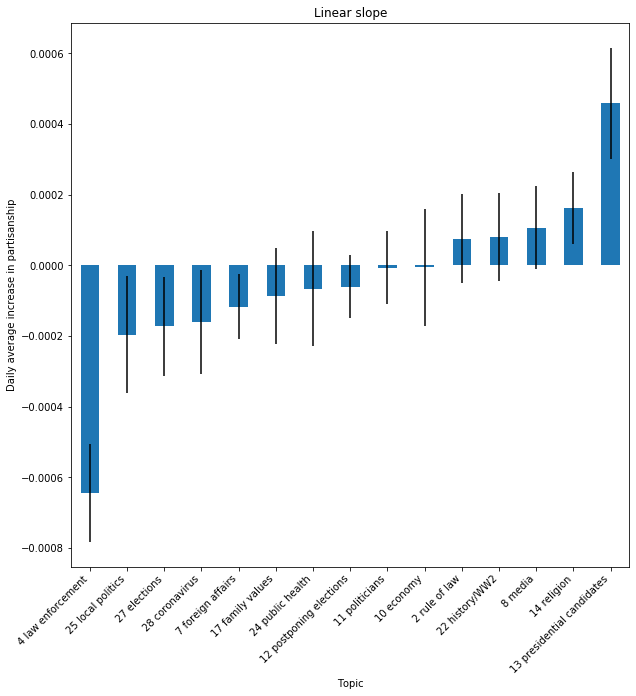

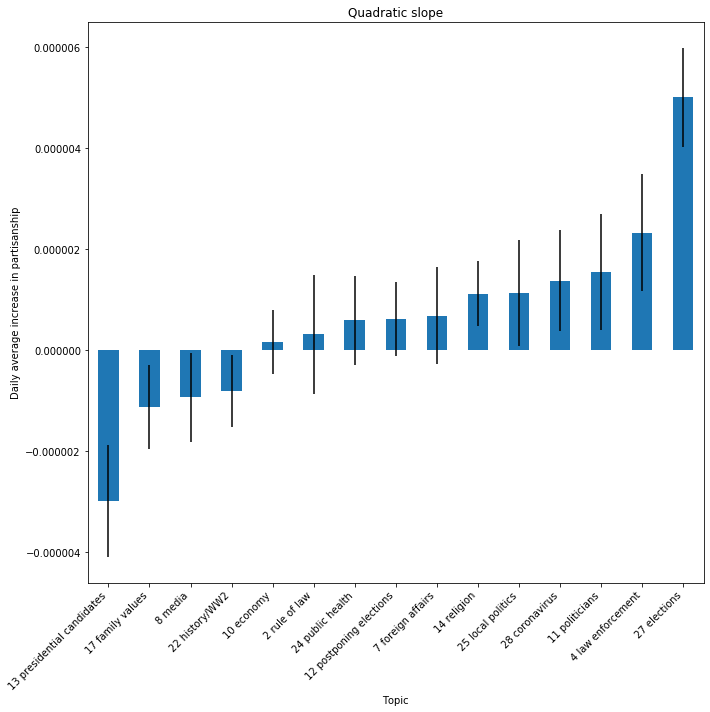

In [212]:
fits_plt = fits[fits['topic'].astype(str).isin(topic_subset)]
axes = fits_plt[fits_plt['coef'] != 'const'].sort_values('point').groupby(['coef']).plot.bar('topic_label','point', figsize=(10, 10), yerr='err')
titles = ['Linear slope', 'Quadratic slope']
varnames = ['const', 'x1']
for i, ax in enumerate(axes):
    ax.get_legend().remove()
    labs = fits_plt[fits_plt['coef'] == varnames[i]].sort_values('point').topic_label.tolist()
    ax.set_xticklabels(labs, rotation = 45, ha='right')
    ax.set_ylabel('Daily average increase in partisanship')
    ax.set_xlabel('Topic')
    ax.set_title(titles[i])
plt.tight_layout()
plt.savefig(os.path.join(PATH, 'final/figures/partisanship_topics_coef_quadratic.png'))
plt.show()

#### Week-level estimates of topic partisanship with confidence intervals

In [8]:
def fit_pol(df, **kwargs):
        model = ModelPolarization(parties=["gov", "opp"], limit=40, n_jobs=1, ngram_range=(1,2))
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        est = model.estimate(df['source'], df['user-id_str'], df['lemmatized'], 
                       text_id = df['id_str'],**kwargs)
        del model
        gc.collect()
        return est

In [11]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_weekly_topics.csv")
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
if os.path.isfile(PATH_RESULTS):
    part_within = pd.read_csv(PATH_RESULTS, index_col = 0)
else:
    part_within = dict() #store estimates
    for df in tqdm(read_files(PATH_DATA, batch_size=7, day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):

        dates = sorted(pd.to_datetime(df['day'].unique()))
        date_start = dates[0].date().strftime('%m/%d')
        date_end = dates[-1].date().strftime('%m/%d')
        date_range = date_start + ' - ' + date_end
        #get estimates by topic:
        df['topic'] = df['id_str'].apply(lambda x: topic_map.get(x))
        part_within_t = df.groupby('topic').parallel_apply(lambda gr: fit_pol(gr, conf_int=100, level='aggregate'))
        part_within_t = part_within_t.to_dict() #convert to dict
        part_within_t = {(k, date_range):v for k, v in part_within_t.items()}
        part_within.update(part_within_t) #update all
    part_within = pd.DataFrame.from_dict(part_within, orient = 'index')
    part_within.index.names = ['topic','date']
    part_within.reset_index(inplace = True)
    part_within.to_csv(PATH_RESULTS)

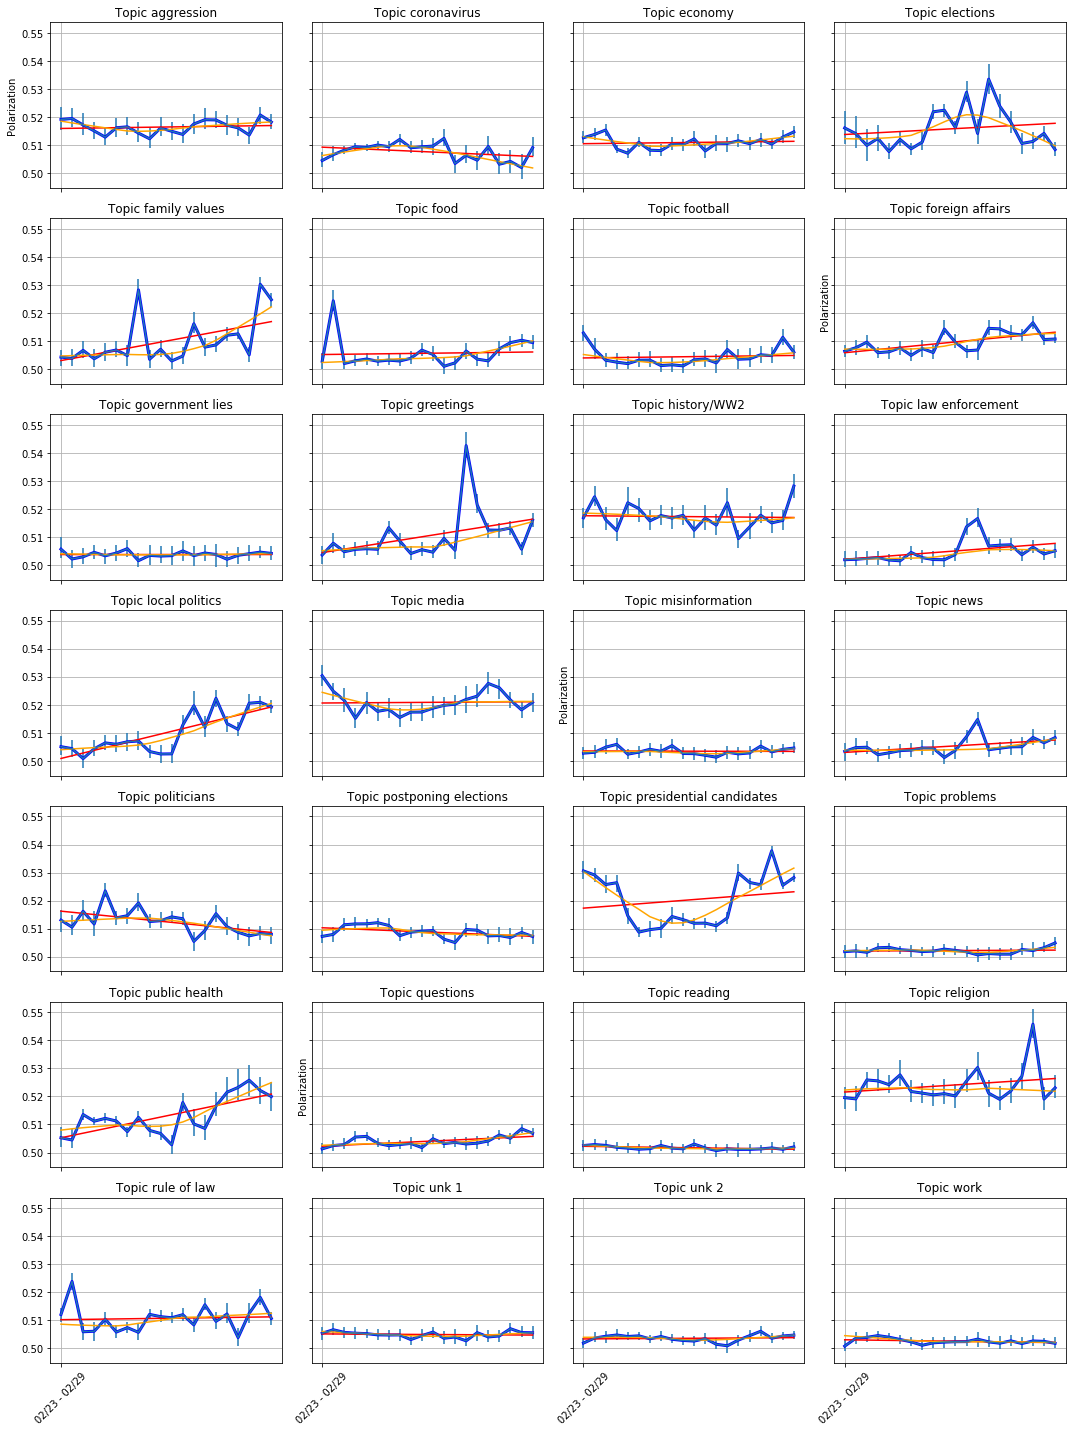

In [12]:
PATH_DICT = os.path.join(PATH, 'results/topics/mallet/topic_dict.json')
part_within[['upper_ci_diff', 'lower_ci_diff']] = np.abs(part_within[['upper_ci','lower_ci']] - part_within['estimate'].to_numpy()[:,np.newaxis])
topic_dict = json.load(open(PATH_DICT, 'r'))
part_within = part_within[part_within['topic'] != 0]
part_within['topic_label'] = part_within['topic'].astype(str).map(topic_dict)
evaluation.plot_aggregated_bytopic(part_within.date, part_within.estimate, part_within.topic_label, 
                                   error=part_within[['upper_ci_diff', 'lower_ci_diff']].to_numpy().T, 
                                   figsize=(15, 20), trend_line=True, lowess=True, dims=(7, 4))
plt.tight_layout()
plt.savefig(os.path.join(PATH, 'final/figures/polarization_topics_weekly.png'), bbox_inches='tight', pad_inches=0.2)
plt.show()

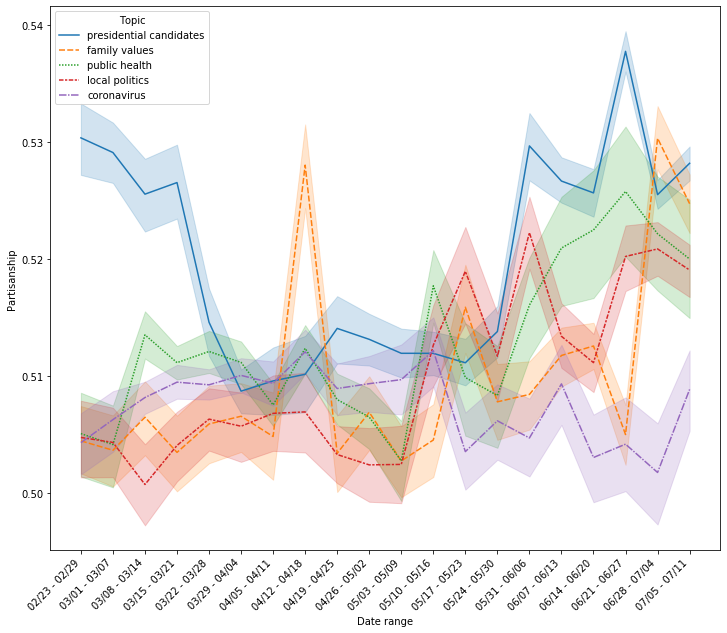

In [46]:
subdf = part_within[part_within['topic_label'].isin(['presidential candidates', 
                                               'public health', 'coronavirus', 
                                               'local politics', 'family values'])]
subdf = subdf.melt(id_vars=['topic','date','topic_label'], 
                   value_vars=['lower_ci','upper_ci','estimate'], 
                   value_name='est')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.lineplot('date', 'est', hue='topic_label', style='topic_label', data=subdf, ci=100, ax=ax)
leg_hand = subdf['topic_label'].unique().tolist() # legend handles
plt.legend(leg_hand, title='Topic')
plt.xticks(rotation=45, horizontalalignment="right")
plt.ylabel('Partisanship')
plt.xlabel('Date range')
plt.show()

### 1.3.  Between-topic partisanship:
I then proceed to compute the daily polarization between topics. The **between-topic** polarization estimate, is defined as the expected posterior probability of assigning a speech to the correct party, assuming the observer knows only the topic, i.e. disregarding the content of the tweets. This allows to evaluate the level of polarization determined only by the topics chosen by the partisans, not by the phrases they use to discuss them.

In [44]:
PATH_RESULTS = os.path.join(PATH, "results/polarization/polarization_daily_between_topics.csv")
if os.path.isfile(PATH_RESULTS):
    part_between = pd.read_csv(PATH_RESULTS, index_col=0)['score']
else:
    part_between = dict()
    for data in tqdm(read_files(PATH_DATA, day_from=START, day_to=END, dtype=dtypes, filter_fun = ff)):
        parties = data["source"] #get parties 
        topics = data['id_str'].astype(str).map(topic_map)
        day = data['day'].unique()[0]
        model = ModelPolarization(parties=["gov", "opp"], limit=40, ngram_range=(1,2))
        part_between[day] = model.estimate_topics(parties, topics)
    part_between = pd.DataFrame.from_dict(part_between, orient='index')
    part_between.columns = ['score']
    part_between = part_between['score']
    part_between.to_csv(PATH_RESULTS)

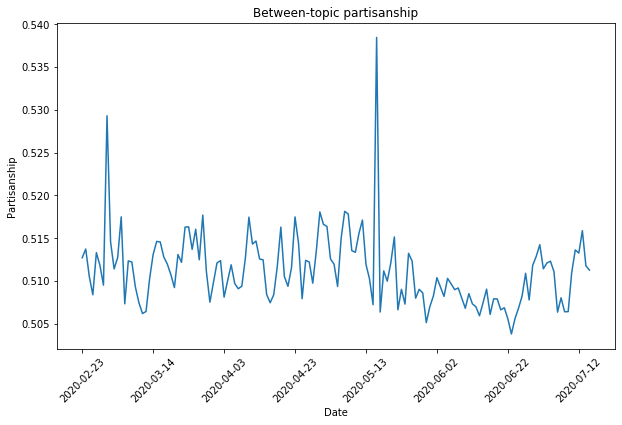

In [46]:
part_between.plot(rot=45, figsize=(10, 6), legend=False, title='Between-topic partisanship')
plt.xlabel('Date')
plt.ylabel('Partisanship')
plt.show()

### 1.4. Comparison of partisanship:

Following Gentzkow et al., to decompose the sources of polarization I calculate **within-topic** polarization as an average of the polarization within each of the identified topic, weighted by the total number of users tweeting on the topic on a given day. I then compare it with the **between-topic** polarization obtained in the previous section. This decomposition provides a way of determining to what extent is the change in polarization over time driven by the difference in which partisans tweet on the same topic vs. the difference in topics on which they tweet.

In [13]:
PATH_BETWEEN = os.path.join(PATH, "results/polarization/polarization_daily_between_topics.csv")
PATH_WITHIN = os.path.join(PATH, "results/polarization/polarization_daily_topics.csv")
PATH_OVERALL = os.path.join(PATH, "results/polarization/polarization_daily.csv")

#BETWEEN PARTISANSHIP
part_between = pd.read_csv(PATH_BETWEEN, index_col = 0)['score']

#WITHIN PARTISANSHIP:
part_within = pd.read_csv(PATH_WITHIN, index_col = 0)
part_within = part_within.reset_index().groupby('date').apply(lambda x: np.average(x['point'], weights = x['n']))

#OVERALL PARTISANSHIP:
part_overall = pd.read_csv(PATH_OVERALL, index_col = 0)
part_overall = part_overall[part_overall['type'] == 'true'].set_index('date')['estimate']

#COMBINE:
part = pd.DataFrame(dict(within = part_within, between = part_between, overall = part_overall))

part = part.reset_index()
part.columns = ['date'] + part.columns.tolist()[1:]
print(part.corr())
part = part.melt(id_vars='date', value_vars=['within', 'between', 'overall'], value_name='score')
part = part.sort_values(['variable','date'])

           within   between   overall
within   1.000000 -0.172235  0.719296
between -0.172235  1.000000  0.267904
overall  0.719296  0.267904  1.000000


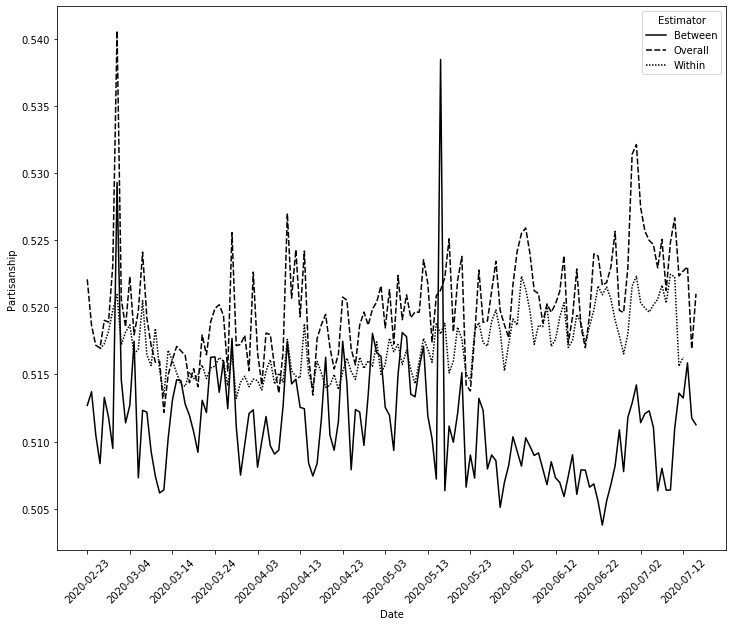

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
g = sns.lineplot('date', 'score', style='variable', data=part, ax=ax, legend=False, color='black')
ax.xaxis.set_tick_params(rotation=45)
ax.xaxis.set_ticks(np.arange(len(part['date'].unique()), step=10))
plt.legend(['Between', 'Overall', 'Within'], title='Estimator')
plt.xlabel('Date')
plt.ylabel('Partisanship')
plt.savefig(os.path.join(PATH, 'final/figures/partisanship_within_between.png'))
plt.show()

The level of partisanship seems to have increased in the topics of presidential candidates, finance, media and decreased in political parties, coronavirus, and elections. 

# 3. Phrase partisanship
To evaluate the partisanship of particular phrases, I obtained the probability pf a phrase being assigned to the government by an observer with neutral prior based on the Gentzkow model. I then looked at phrases which occured on at least 115 days (i.e. less than 40 days missingness), and examined phrases with highest government partisanship (i.e. probability close to 1), opposition partisanship (i.e. probability close to 0) and highest variation in partisanship over time.

In [43]:
PATH_RES = os.path.join(PATH, 'results/polarization/phrase_partisanship.csv')
if os.path.isfile(PATH_RES):
    phrases = pd.read_csv(PATH_RES, index_col = 'date')
else:
    phrases = dict()
    for df in tqdm(read_window(PATH_DATA, window_size=7,  batch_size=1, 
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        
        #fit vectorizer on all vocabulary:
        model = ModelPolarization(parties = ["gov", "opp"], limit=40, ngram_range=(1,2), log=20)
        model.prefit(df["lemmatized"].astype(str).to_numpy())
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        parties = df["source"] #get parties 
        users = df["user-id_str"] #get users 
        tweets = df["lemmatized"].astype(str) #get tweets
        day = df['day'].unique()[0]
        model = ModelPolarization(parties = ["gov", "opp"], limit=40, ngram_range=(1,2))
        phrases[mid_date] = model.estimate_phrases(parties, users, tweets)
    phrases = pd.DataFrame.from_dict(phrases).reset_index().melt('index')
    phrases.columns = ['phrase','date','prob']
    phrases = phrases.set_index(['date'])
    phrases.to_csv(PATH_RES)

In [44]:
phrases = phrases[np.logical_not(phrases.phrase.isin(stopwords))]
summary = phrases.groupby('phrase').agg({'prob':[np.mean, np.std, lambda x: x.isna().sum()]})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['prob_mean','prob_sd','prob_miss']

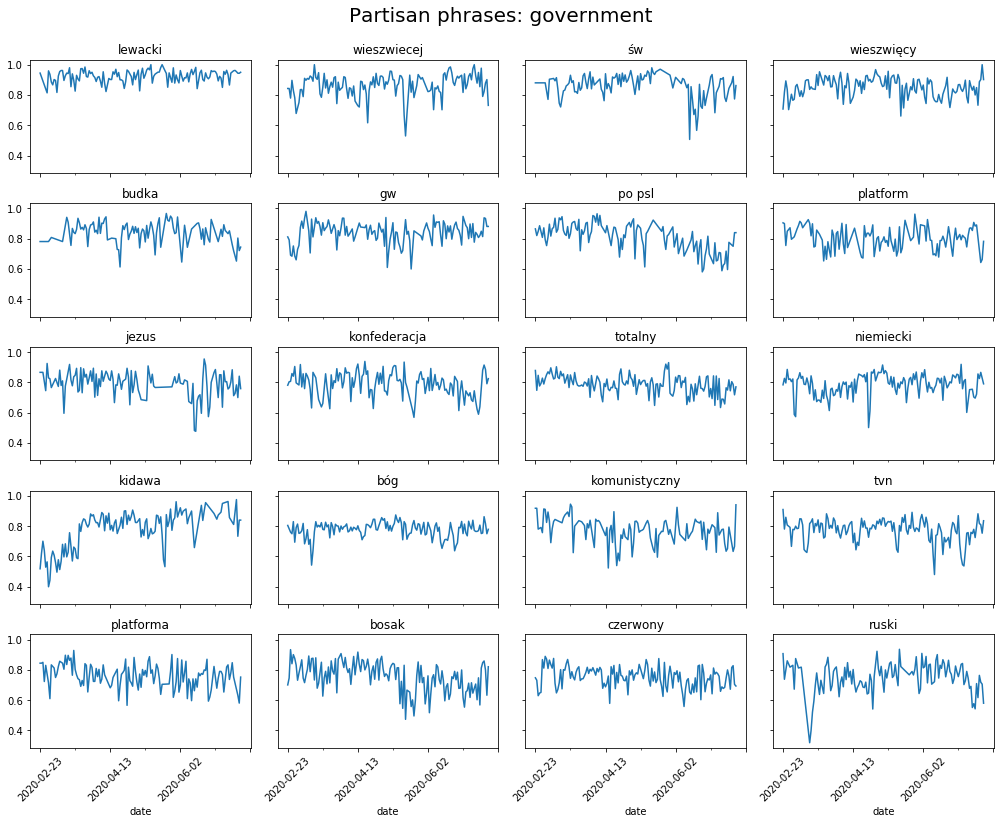

In [13]:
phrases_gov = summary[summary.prob_miss < 40].sort_values(['prob_mean'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize=(14, 12), sharex=True, sharey=True)
fig.suptitle('Partisan phrases: government', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_gov.phrase):
    phrases[phrases.phrase == phr].prob.interpolate(method='linear',limit_direction='both').plot(rot=45, ax=ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

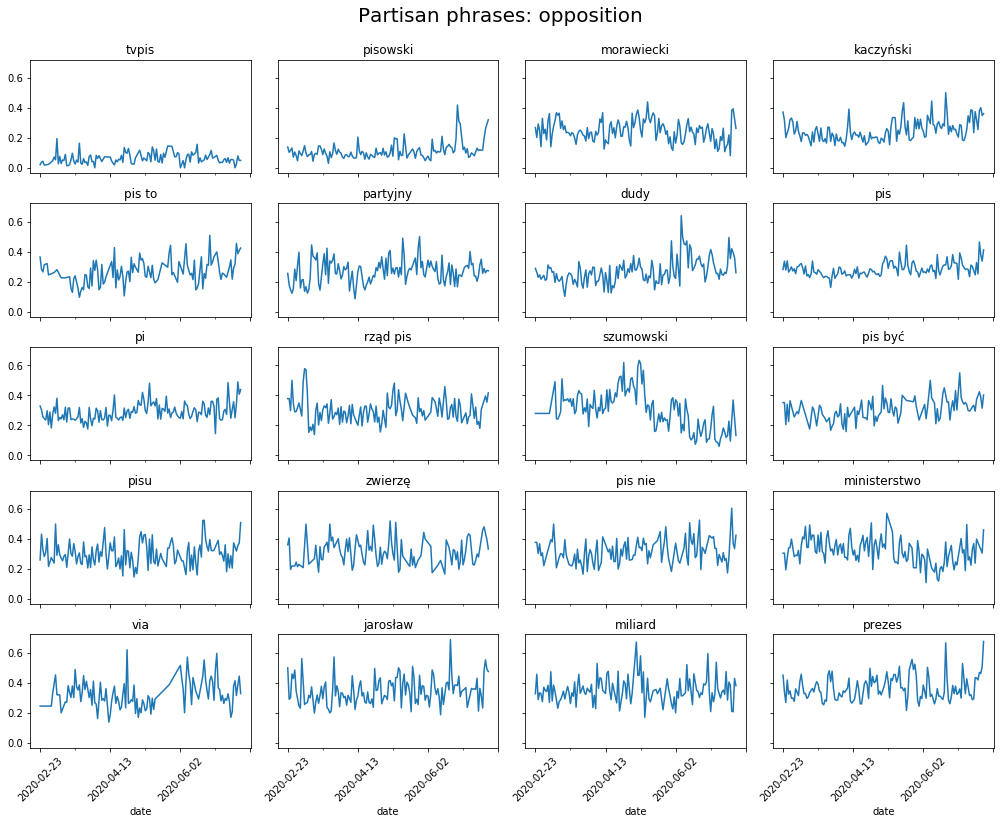

In [14]:
phrases_opp = summary[summary.prob_miss < 40].sort_values(['prob_mean'], ascending = True).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Partisan phrases: opposition', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_opp.phrase):
    phrases[phrases.phrase == phr].prob.interpolate(method='linear',limit_direction='both').plot(rot=45, ax=ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

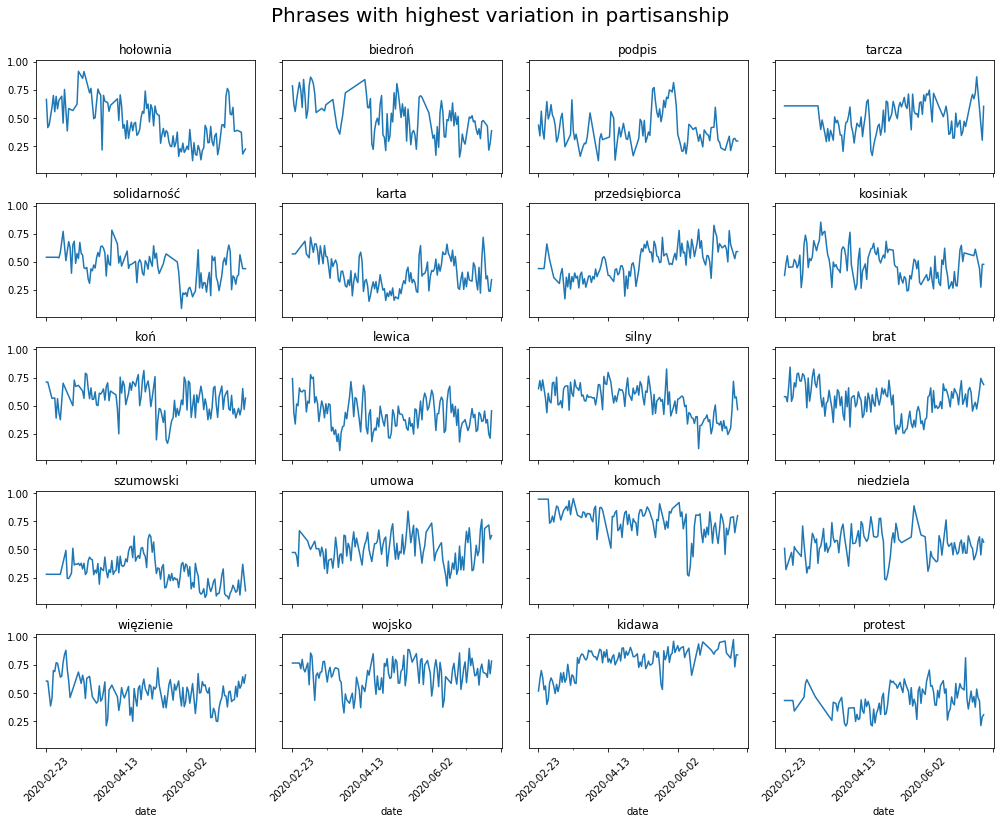

In [15]:
phrases_var = summary[summary.prob_miss < 40].sort_values(['prob_sd'], ascending = False).iloc[:20].reset_index()
fig, ax = plt.subplots(5, 4, figsize = (14, 12), sharex = True, sharey = True)
fig.suptitle('Phrases with highest variation in partisanship', fontsize = 20)
ax = ax.ravel()
for i, phr in enumerate(phrases_var.phrase):
    phrases[phrases.phrase == phr].prob.interpolate(method='linear',limit_direction='both').plot(rot=45, ax=ax[i])
    ax[i].set_title(f'{phr}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### By topic:
**Compute partisanship of unigrams and bigrams for each of the topics.**

In [6]:
def polarization(sources:list, users:list, texts:list):
    """
    Estiamte phrase polarization. Utility function to apply over groupped DataFrame
    """
    model = ModelPolarization(parties = ["gov", "opp"], limit=10, ngram_range=(1,2), log=20, stop_words=stopwords)
    prob = model.estimate_phrases(sources, users, texts)
    #tokenize:
    tokens = nltk.word_tokenize("\n".join(texts.tolist()))
    tokens = [w for w in tokens if w in list(model.vectorizer.vocabulary_.keys())] #stopwords and under min_df

    #get bigram counts:
    bgs = nltk.bigrams(tokens)
    counts = nltk.FreqDist(bgs)
    counts = {" ".join(k):v for k, v in counts.items()}
    #and unigram counts:
    counts.update(nltk.FreqDist(tokens))
    res = dict()
    for w in prob:
        res[w] = {'score':prob[w], 'n':counts[w]}
    del model
    gc.collect()
    return res

In [12]:
PATH_RES = os.path.join(PATH, 'results/polarization/phrase_partisanship_bytopic.csv')
PATH_TOPICS = os.path.join(PATH, 'results/topics/mallet/topic_map.json')
topic_map = json.load(open(PATH_TOPICS, 'r'))
if os.path.isfile(PATH_RES):
    phrases = pd.read_csv(PATH_RES, index_col=0)
else:
    phrases = dict()
    for df in tqdm(read_window(PATH_DATA, n=7,  batch_size=1, 
                               day_from=START, day_to=END, dtype=dtypes, filter_fun=ff)):
        
        #fit vectorizer on all vocabulary:
        date_range = sorted(pd.to_datetime(df.day.unique()))
        mid_date = date_range[3].date().strftime('%Y-%m-%d')
        df = df[df['day'] == mid_date]
        df['topic'] = df['id_str'].apply(lambda x: topic_map.get(x))
        #get phrase probabilities
        phrases_bytopic = df.groupby('topic').parallel_apply(lambda gr: polarization(gr['source'], gr['user-id_str'], gr['lemmatized']))
        phrases_bytopic = phrases_bytopic.to_dict()
        for topic, res in phrases_bytopic.items():
            for w in res:
                phrases[(mid_date, topic, w)] = res[w]
    phrases = pd.DataFrame.from_dict(phrases, orient = 'index')
    phrases.reset_index(inplace = True)
    phrases.columns = ['date','topic','phrase', 'score', 'n']
    phrases.set_index(['topic','phrase'], inplace = True)
    phrases['num_days'] = phrases.groupby(phrases.index).size()
    phrases = phrases.reset_index()
    phrases.to_csv(PATH_RES)

#### Get aggregate phrase counts:

In [13]:
# get the weughted average of polarization for each token:
phrase_agg = phrases.groupby(['topic', 'phrase', 'num_days']).apply(lambda x: weighted_average(x)).reset_index()

# keep only tokens that occured on more than 30% of the days:
phrase_agg = phrase_agg[phrase_agg.num_days >= 0.3 * len(phrase_agg.num_days.unique())]
phrase_agg.columns = phrase_agg.columns.tolist()[:-1] + ['score']

# get topic label:
phrase_agg['topic_label'] = phrase_agg['topic'].astype(str).map(topic_dict)

#### Get top 10 tokens in each category

In [14]:
phrase_pol_opp = (phrase_agg
                       .sort_values(['topic_label', 'score'])
                       .groupby('topic_label')
                       .head(10)
                       .rename(columns = {'phrase':'phrase_opp'})
                       .reset_index())[['topic_label','topic', 'phrase_opp', 'score']]
phrase_pol_gov = (phrase_agg
                       .sort_values(['topic_label', 'score'],ascending =[True, False])
                       .groupby('topic_label')
                       .head(10)
                       .rename(columns = {'phrase':'phrase_gov'})
                       .reset_index())[['phrase_gov']]
phrase_pol = pd.concat([phrase_pol_opp, phrase_pol_gov], axis=1)
phrase_pol = phrase_pol.groupby(['topic', 'topic_label']).agg({'phrase_opp': lambda x: ", ".join(x), 
                                                               'phrase_gov': lambda x: ", ".join(x)})
pd.set_option('display.max_colwidth', 150)
phrase_pol

,,phrase_opp,phrase_gov
topic,topic_label,,
0,multiple,"tvpis, sasin, suweren, pisowski, adrian, pisowiec, jarek, dudy, morawiecki, kaczyński","niezalezny pl, dubler, wtylewizja, niezalezny, lewacki, wieszwiecej, lewactwo, wieszwięcy, nitras, budka"
1,greetings,"cześć, mówić, miły wieczór, popołudnie, trzymać kciuk, kciuk, spokojny dzień, wieczór, pogoda, sen","bóg, prawy, duda, pozdrawiać serdecznie, kobieta, dobry spokojny, polska, witać, serdecznie, obserwować"
2,rule of law,"pisowski, kaczyński, pis, ziobro, duda, podstawa prawny, krs, równy, tryb, partia","kasta, reforma, gersdorf, opozycja, tsue, wsec, koniec, nadzwyczajny, polak, prezes sn"
3,aggression,"pisowski, pis, kaczyński, sort, propaganda, zdradziecki, duda, władza, dziad, kłamca","lewacki, rudy, tw, lewactwo, tęczowy, sb, won, czerwony, trzaskowski, tusk"
4,law enforcement,"mgła, cień, ostry, duda, pis, władza, kraj, policjant, czuć, prawo","opozycja, świat, trzaskowski, koronawirus, polak, stawać, niektóry, stosować, podobny, zachowanie"
5,football,"jarek, pis, musieć, początek, akurat, zaczynać, myśleć, dopiero, raczej, koniec","piłkarz, kibic, szambo, polski, piłka, nadawać, polska, pierwszy, chodzić, klub"
6,reading,"pis, duda, głosować, przekonać, prawy strona, ok, wybory, raz nie, połowa, ostatni","dama, ban, opozycja, obserwować, tweet, nie potrafić, polska, polak, czytać, potrafić"
7,foreign affairs,"wspólnota, pis, morawiecki, białoruś, unia europejski, trump, unia, amerykanin, mieszkać, otworzyć","niezalezny pl, niezalezny, defenka, berlin, opozycja, tusk, brukseli, niemiecki, bezpieczeństwo, hiszpania"
8,media,"wypad, pi, pis, afera, publiczny, silni razem, propaganda, silni, tvp, kaczyński","gw, nitras, sok burak, burak, budka, sok, platform, fake news, lis, platforma"


#### Write to CSV and LaTex:

In [22]:
phrase_pol_tex = phrase_pol.reset_index().to_latex(index=False, column_format='p{2cm}p{2cm}p{5cm}p{5cm}', 
                                                   header=['topic number', 'topic label', 'opposition phrases', 'government phrases'])
open(os.path.join(PATH, 'final/tables/party_phrases_pol_full.tex'), 'w').write(phrase_pol_tex)
phrases_filt_en.to_csv(os.path.join(PATH, 'final/tables/party_phrases_pol_full.csv'))

8486

#### Translate to English:

In [36]:
man_ann = {'odporność':'immunity', 'testować':'to test', 'owsiak':'Owsiak', 
           'Ziobro':'ziobro', 'duda':'Duda',
           'bagpipe':'Duda', 
           'sok burak':'sok burak', 'sok': 'sok', 'burak':'burak', 
           'padz pałac':'PAD out of palace', 'szczecin':'Szczecin', 
           'duda prezydent': 'Duda president', 'lokal':'station',
           'wieszwięcy':'knowmore','dubler':'double', 'hejter':'hater',
           'jasny góra':'Jasna Góra', 'czajka':'Czajka', 'witek':'Witek',
           'duda nie':'not Duda', 'lek': 'medicine', 'biedron':'Biedron', 
           'bosak':'Bosak', 'pis':'PiS', 
           'budka': 'Budka'} #manual annotatio
phrase_pol_en = phrase_pol.applymap(lambda x: ', '.join(translate(x.split(', '), retry_lim=5, manual=man_ann)))

In [56]:
phrase_pol_en

,,phrase_opp,phrase_gov
topic,topic_label,,
0,multiple,"tvpis, sasin, sovereign, pisowski, adrian, writer, jarek, bagpipe, Morawiecki, Kaczynski","independent pl, double, recession, independent, leftist, more, leftism, knowmore, nitras, Budka"
1,greetings,"Hello, speak, nice evening, afternoon, hold your thumb, thumb, a calm day, evening, weather, dream","God, right, Duda, greet cordially, woman, good calm, Poland, greet, heartily, observe"
2,rule of law,"pisowski, Kaczynski, PiS, ribs, Duda, legal basis, krs, equal, mode, party","caste, reform, gersdorf, opposition, tsue, insert, end, extraordinary, Pole, president of sn"
3,aggression,"pisowski, PiS, Kaczynski, sort, propaganda, treacherous, Duda, authority, grandfather, liar","leftist, ore, tw, leftism, rainbow, Sat, won, red, Trzaskowski, tusk"
4,law enforcement,"fog, shadow, sharp, Duda, PiS, authority, country, police officer, feel, right","opposition, world, Trzaskowski, coronavirus, Pole, to stop, one, use, similar, behavior"
5,football,"jarek, PiS, must, beginning, exactly, start, think, only, rather, end","footballer, waist, septic tank, Polish, ball, broadcast, Poland, first, go, club"
6,reading,"PiS, Duda, vote, convince, right side, okay, elections, once not, half, last","lady, ban, opposition, observe, tweet, Can not, Poland, Pole, read, be able"
7,foreign affairs,"community, PiS, Morawiecki, Belarus, European union, trump, union, American, live, open","independent pl, independent, defenka, Berlin, opposition, tusk, Brussels, German, security, Spain"
8,media,"excursion, pi, PiS, affair, public, strong together, propaganda, strong, tvp, Kaczynski","gw, nitras, sok burak, burak, Budka, sok, platforms, fake news, Nov, platform"


#### Annotate political proper nouns:

In [ ]:
def annotate(phrases:str, annotations:dict, split=', '):
    phrases = phrases.split(split)
    for i, phr in enumerate(phrases):
        for word, ann in annotations.items():
            if re.search(word, phr, re.IGNORECASE):
                phrases[i] += ' ' + ann
                break
    return split.join(phrases)

annotations = {'tvpis':'[mock name for state TV]', 
               'Budka':'[opposition leader]', 
               'Kaczynski':'[PiS leader]', 
               'PiS':'[governing party]', 
               'Duda':'[incumbent president]', 
               'Trzaskowski':'[opposition presidential candidate, Mayor of Warsaw]', 
               'gw':'[liberal newspaper]', 
               'jarek':'[Kaczynski]', 
               'sok':'[online opposition platform]', 
               'Szumowski':'[Health Minister]', 
               'Witek':'[Speaker of the Parliament]', 
               'Nitras':'[opposition MP]', 
               'Smolensk':'[location of 2010 presidential plane crash]', 
               'sanepid':'[CDC equivalent]', 
               'Sasin':'[Interior Minister]', 
               'Czajka':'[malfunctioning sewage treatment plant in Warsaw]', 
               'Owsiak':'[liberal health activist]'}

In [58]:
phrase_pol_en['phrase_opp'] = phrase_pol_en['phrase_opp'].apply(lambda x: annotate(x, annotations=annotations))
phrase_pol_en['phrase_gov'] = phrase_pol_en['phrase_gov'].apply(lambda x: annotate(x, annotations=annotations))

In [61]:
pd.set_option('display.max_colwidth', 200)
phrase_pol_en

,,phrase_opp,phrase_gov
topic,topic_label,,
0,multiple,"tvpis [mock name for state TV], sasin [Interior Minister], sovereign, pisowski [governing party], adrian, writer, jarek [Kaczynski], bagpipe, Morawiecki, Kaczynski [PiS leader]","independent pl, double, recession, independent, leftist, more, leftism, knowmore, nitras [opposition MP], Budka [opposition leader]"
1,greetings,"Hello, speak, nice evening, afternoon, hold your thumb, thumb, a calm day, evening, weather, dream","God, right, Duda [incumbent president], greet cordially, woman, good calm, Poland, greet, heartily, observe"
2,rule of law,"pisowski [governing party], Kaczynski [PiS leader], PiS [governing party], ribs, Duda [incumbent president], legal basis, krs, equal, mode, party","caste, reform, gersdorf, opposition, tsue, insert, end, extraordinary, Pole, president of sn"
3,aggression,"pisowski [governing party], PiS [governing party], Kaczynski [PiS leader], sort, propaganda, treacherous, Duda [incumbent president], authority, grandfather, liar","leftist, ore, tw, leftism, rainbow, Sat, won, red, Trzaskowski [opposition presidential candidate, Mayor of Warsaw], tusk"
4,law enforcement,"fog, shadow, sharp, Duda [incumbent president], PiS [governing party], authority, country, police officer, feel, right","opposition, world, Trzaskowski [opposition presidential candidate, Mayor of Warsaw], coronavirus, Pole, to stop, one, use, similar, behavior"
5,football,"jarek [Kaczynski], PiS [governing party], must, beginning, exactly, start, think, only, rather, end","footballer, waist, septic tank, Polish, ball, broadcast, Poland, first, go, club"
6,reading,"PiS [governing party], Duda [incumbent president], vote, convince, right side, okay, elections, once not, half, last","lady, ban, opposition, observe, tweet, Can not, Poland, Pole, read, be able"
7,foreign affairs,"community, PiS [governing party], Morawiecki, Belarus, European union, trump, union, American, live, open","independent pl, independent, defenka, Berlin, opposition, tusk, Brussels, German, security, Spain"
8,media,"excursion, pi, PiS [governing party], affair, public, strong together, propaganda, strong, tvp, Kaczynski [PiS leader]","gw [liberal newspaper], nitras [opposition MP], sok burak [online opposition platform], burak, Budka [opposition leader], sok [online opposition platform], platforms, fake news, Nov, platform"


#### Filter out topics and write to csv and LaTeX:

In [66]:
phrase_pol_en_tex = phrase_pol_en.reset_index().to_latex(index=False, column_format='p{2cm}p{2cm}p{5cm}p{5cm}', 
                                                   header=['topic number', 'topic label', 'opposition phrases', 'government phrases'])
open(os.path.join(PATH, 'final/tables/party_phrases_pol_en_full.tex'), 'w').write(phrase_pol_en_tex)
phrase_pol_en.to_csv(os.path.join(PATH, 'final/tables/party_phrases_pol_en_full.csv'))

In [78]:
phrases_filt_en = phrase_pol_en[phrase_pol_en['topic'].astype(str).isin(topic_subset)]
phrases_filt_en.reset_index(inplace=True)
phrases_filt_en.drop('topic', axis=1, inplace=True)
phrases_filt_en = phrase_pol_en[phrase_pol_en['topic'].astype(str).isin(topic_subset)]

phrase_pol_en_tex = phrases_filt_en.to_latex(index=False, column_format='p{2cm}p{6cm}p{6cm}', 
                                                   header=['topic label', 'opposition phrases', 'government phrases'])
open(os.path.join(PATH, 'final/tables/party_phrases_pol_en.tex'), 'w').write(phrase_pol_en_tex)
phrases_filt_en.to_csv(os.path.join(PATH, 'final/tables/party_phrases_pol_en_full.csv'))

In [455]:
@interact
def show_articles_more_than(topic=list(sorted(phrase_agg.topic_label.unique())), 
                            group=['all', 'government', 'opposition'], topn=5):
    df = phrase_agg.reset_index(drop=True)
    if group == 'government':
        ind = df['score'].groupby(df['topic_label']).nlargest(n=topn).index.droplevel(0)
        df = df.iloc[ind]
    elif group == 'opposition':
        ind = df['score'].groupby(df['topic_label']).nsmallest(n=topn).index.droplevel(0)
        df = df.iloc[ind]  
    elif group == 'all':
        df = phrase_agg
    return df.loc[df['topic_label'] == topic]

interactive(children=(Dropdown(description='topic', options=('aggression', 'cities', 'coronavirus', 'economy',…